In [1]:
%load_ext autoreload
%autoreload 2

In [38]:
import numpy as np
import random
import math
from pydrake.common import temp_directory
from pydrake.geometry import StartMeshcat
from pydrake.systems.analysis import Simulator
from pydrake.visualization import ModelVisualizer
from pydrake.all import Simulator, StartMeshcat, LogVectorOutput

from manipulation import running_as_notebook
from manipulation.station import MakeHardwareStation, load_scenario
from IPython.display import HTML, display
from matplotlib import pyplot as plt
from pydrake.all import (
    AddMultibodyPlantSceneGraph,
    Box,
    ConnectPlanarSceneGraphVisualizer,
    DiagramBuilder,
    FixedOffsetFrame,
    JointIndex,
    Parser,
    PlanarJoint,
    RandomGenerator,
    RigidTransform,
    RotationMatrix,
    Simulator,
    StartMeshcat,
    UniformlyRandomRotationMatrix,
)

from manipulation import ConfigureParser, running_as_notebook
from manipulation.scenarios import AddShape, ycb
from manipulation.station import MakeHardwareStation, load_scenario
from pydrake.common import temp_directory

# sponana/src/sponana/utils.py
import sponana.utils
from sponana.controller import SpotController
from sponana.debug_logger import DebugLogger
from sponana.perception import (
    add_camera_pose_extractor,
    add_body_pose_extractor,
    BananaSpotter,
)
import sponana.sim

In [3]:
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at http://localhost:7001


Logging system info...
Camera pose: RigidTransform(
  R=RotationMatrix([
    [-0.00818712402036053, 0.49998324246925385, -0.8659963788897772],
    [0.9999664849385079, 0.004093562010180263, -0.007090257385566005],
    [0.0, -0.8660254037844387, -0.4999999999999999],
  ]),
  p=[0.6201394909272053, 0.018566504925796912, 0.495],
)
Table 0 pose: RigidTransform(
  R=RotationMatrix([
    [1.0, 0.0, 0.0],
    [0.0, 1.0, 0.0],
    [0.0, 0.0, 1.0],
  ]),
  p=[0.0, 0.0, 0.19925],
)
Table 1 pose: RigidTransform(
  R=RotationMatrix([
    [1.0, 0.0, 0.0],
    [0.0, 1.0, 0.0],
    [0.0, 0.0, 1.0],
  ]),
  p=[0.0, 2.0, 0.19925],
)
Table 2 pose: RigidTransform(
  R=RotationMatrix([
    [1.0, 0.0, 0.0],
    [0.0, 1.0, 0.0],
    [0.0, 0.0, 1.0],
  ]),
  p=[0.0, -2.0, 0.19925],
)


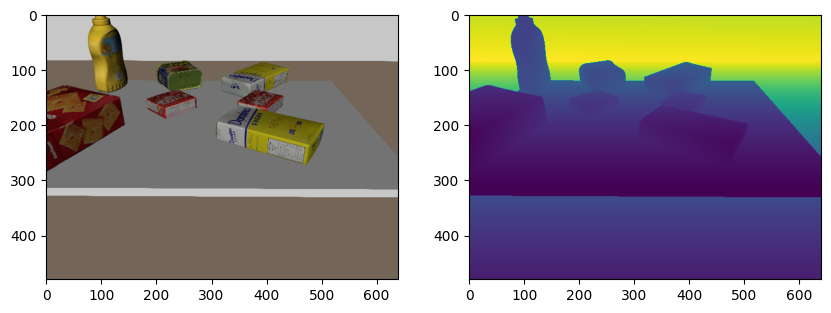

In [11]:
# Clean up the Meshcat instance.
meshcat.Delete()
meshcat.DeleteAddedControls()

rng = np.random.default_rng(145)  # this is for python
generator = RandomGenerator(rng.integers(0, 1000))  # this is for c++

add_spot = True
simulation_time = -1  # run indefinitely until ESC is pressed
# simulation_time = 1
table_height = 0.2
debug = True
add_fixed_cameras = False

simulator, diagram = sponana.sim.clutter_gen(
    meshcat,
    rng,
    table_height=table_height,
    debug=debug,
    simulation_time=simulation_time,
    add_spot=add_spot,
    add_fixed_cameras=add_fixed_cameras,
)

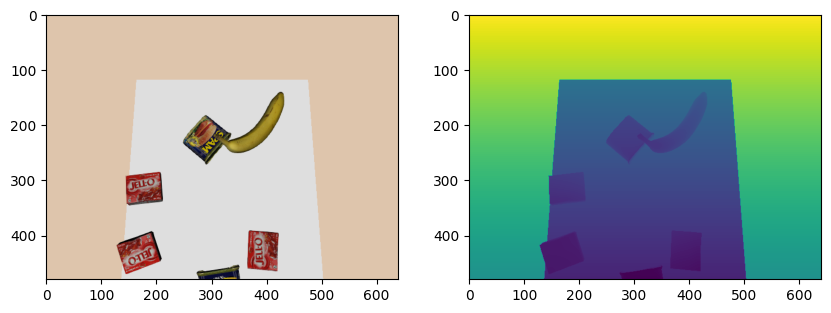

In [ ]:
# Check the camera on table top
context = simulator.get_mutable_context()
station = diagram.GetSubsystemByName("station")
context = station.GetMyContextFromRoot(context)
color_image = station.GetOutputPort("camera0.rgb_image").Eval(context)
depth_image = station.GetOutputPort("camera0.depth_image").Eval(context)
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(color_image.data)
plt.subplot(1, 2, 2)
plt.imshow(depth_image.data)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=3d6be65c-ca3c-46d4-a8f3-21f3622a2ace' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>

In [ ]:
# Check the camera on Spot
context = simulator.get_mutable_context()
station = diagram.GetSubsystemByName("station")
context = station.GetMyContextFromRoot(context)
color_image = station.GetOutputPort("spot_camera.rgb_image").Eval(context)
depth_image = station.GetOutputPort("spot_camera.depth_image").Eval(context)
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(color_image.data)
plt.subplot(1, 2, 2)
plt.imshow(depth_image.data)

RuntimeError: System station does not have an output port named camera1.rgb_image (valid port names: spot.state_estimated, camera0.rgb_image, camera0.depth_image, camera0.label_image, spot_camera.rgb_image, spot_camera.depth_image, spot_camera.label_image, query_object, contact_results, plant_continuous_state, body_poses)

In [ ]:
# camera intrinsics
camera1 = station.GetSubsystemByName("rgbd_sensor_spot_camera")
camera_info = camera1.depth_camera_info()
print("intrinsics", camera_info.intrinsic_matrix())
print("focal length", camera_info.focal_x(), camera_info.focal_y())
print("field of view", camera_info.fov_x(), camera_info.fov_y())

In [ ]:
# Another way to get camera pose (X_PC)
context = simulator.get_mutable_context()
context = camera1.GetMyContextFromRoot(context)
camera1.GetOutputPort("body_pose_in_world").Eval(context)

In [ ]:
# Read out the table position from the hardware station

plant = station.GetSubsystemByName("plant")
context = simulator.get_mutable_context()
pcontext = plant.GetMyContextFromRoot(context)
idx = plant.GetBodyByName(
    "table_top_link", plant.GetModelInstanceByName("table_top0")
).index()  # Get this
# get output port with body_poses
# then index into it by index -- see get_body_poses_output_port() docs!!
plant.get_body_poses_output_port().Eval(pcontext)[idx]

In [ ]:
sponana.utils.visualize_diagram(diagram, max_depth=1)